Majda KEMMOU

# Education vs Fertility: A comprehensive bootstrap analysis

## Theoretical framework (based on Efron & Tibshirani 1993)

This notebook performs a bootstrap analysis of the relationship between female education and fertility rates, following the principles from *Efron & Tibshirani (1993)*. The bootstrap method is particularly valuable when:
- The sampling distribution of the statistic is unknown
- Sample sizes are small
- Distributional assumptions are questionable
- Complex estimators are used

As discussed in Chapter 1 of the lecture notes, bootstrap resampling allows us to estimate:
1. The sampling distribution of statistics
2. Standard errors and bias
3. Confidence intervals
4. Significance of observed effects

We apply these concepts to analyze how education levels correlate with fertility rates across different years.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Loading and exploration of the Gapminder Data

We will examine the relationship between two variables: education and fertility.

In [20]:
edu = pd.read_csv('education.csv')
fert = pd.read_csv('fertility.csv')

print("Education data columns:", edu.columns.tolist())
print("Fertility data columns:", fert.columns.tolist())

# preview of the data
print("\nEducation data sample:")
display(edu.head())
print("\nFertility data sample:")
display(fert.head())

Education data columns: ['country', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
Fertility data columns: ['country', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

Education data sample:


,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,0.11,0.12,0.12,0.12,0.13,0.13,0.14,0.14,0.15,...,0.39,0.40,0.42,0.43,0.45,0.46,0.48,0.49,0.51,0.53
1,Angola,0.47,0.49,0.50,0.52,0.54,0.56,0.58,0.60,0.62,...,1.57,1.62,1.68,1.73,1.79,1.84,1.90,1.96,2.03,2.09
2,Albania,4.38,4.50,4.62,4.74,4.86,4.99,5.12,5.25,5.38,...,9.75,9.92,10.10,10.30,10.40,10.60,10.80,10.90,11.10,11.30
3,Andorra,5.38,5.52,5.65,5.79,5.93,6.07,6.22,6.36,6.51,...,11.10,11.30,11.40,11.60,11.80,11.90,12.10,12.20,12.40,12.60
4,UAE,1.06,1.11,1.15,1.20,1.25,1.30,1.35,1.41,1.47,...,4.92,5.07,5.22,5.37,5.52,5.68,5.83,5.98,6.14,6.30



Fertility data sample:


,country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,4.57,4.42,4.26,4.11,3.94,3.80,3.62,3.45,3.28,...,1.94,1.90,1.85,1.78,1.73,1.70,1.66,1.63,1.61,1.60
1,Afghanistan,7.28,7.28,7.29,7.30,7.30,7.30,7.32,7.34,7.36,...,5.77,5.65,5.54,5.43,5.33,5.24,5.14,5.04,4.93,4.84
2,Angola,6.71,6.79,6.87,6.95,7.04,7.12,7.19,7.27,7.33,...,5.86,5.77,5.69,5.60,5.52,5.44,5.37,5.30,5.21,5.12
3,Albania,6.38,6.27,6.11,5.93,5.71,5.47,5.33,5.31,5.32,...,1.72,1.63,1.55,1.49,1.42,1.40,1.37,1.36,1.35,1.35
4,Andorra,2.54,2.54,2.55,2.60,2.69,2.71,2.76,2.78,2.77,...,1.17,1.22,1.18,1.13,1.05,1.04,1.03,1.06,1.07,1.08


## 3. The bootstrap analysis function

Building upon Section 3.2 of the lecture notes about correlation coefficients, we implement a comprehensive bootstrap function that:
- Calculates observed correlation
- Generates bootstrap samples (as in Section 1.3.2)
- Estimates standard error (Section 3.1.6)
- Computes bias (Chapter 10)
- Calculates confidence intervals (Section 1.3.4)
- Performs hypothesis testing

In [21]:
def analyze_year(year, n_boot=2000):
    """
    bootstrap analysis for a given year
    
    parameters:
        year (str): Year to analyze
        n_boot (int): Number of bootstrap samples (following Section 3.3 guidelines)
        
    returns:
        dict: Dictionary containing all analysis results
    """
    # i merge and clean the data
    df = pd.merge(
        edu[['country', year]].rename(columns={year: 'education'}),
        fert[['country', year]].rename(columns={year: 'fertility'}),
        on='country'
    ).dropna()
    
    # i calculate observed correlation (Section 3.2.1)
    r_obs, _ = pearsonr(df['education'], df['fertility'])
    
    # bootstrap resampling (Section 1.3.2)
    boot_corrs = []
    n = len(df)
    
    for _ in range(n_boot):
        # i generate bootstrap sample 
        sample = df.sample(n=n, replace=True)
        r = pearsonr(sample['education'], sample['fertility'])[0]
        boot_corrs.append(r)
    
    boot_corrs = np.array(boot_corrs)
    
    # I calculate some statistics (Chapter 3 & 10)
    ci = np.percentile(boot_corrs, [2.5, 97.5]) # 95% CI 
    se = np.std(boot_corrs, ddof=1)  # Standard error 
    bias = np.mean(boot_corrs) - r_obs # Bias 
    
    # Hypothesis test H0: rho = 0 
    pval = np.mean(np.abs(boot_corrs) >= np.abs(r_obs))
    
    # Normal approximation CI (for comparison)
    norm_ci = norm.interval(0.95, loc=r_obs, scale=se)
    
    return {
        'year': year,
        'r_obs': r_obs,
        'ci': ci,
        'se': se,
        'bias': bias,
        'pval': pval,
        'boot_corrs': boot_corrs,
        'data': df,
        'norm_ci': norm_ci
    }

## 4. Application of bootstrap analysis across years

We analyze multiple years to examine the consistency of the relationship.

In [22]:
years = ['1980','1990', '2000', '2010']
results = {}

for y in years:
    print(f"Analyzing year {y}...")
    results[y] = analyze_year(y, n_boot=2000) # B=2000 for better accuracy 

Analyzing year 1980...
Analyzing year 1990...
Analyzing year 2000...
Analyzing year 2010...


## 5. Comprehensive Results Table


In [23]:
# I create detailed summary table with additional statistics
summary = pd.DataFrame({
    y: {
        'Pearson r': res['r_obs'],
        'Bootstrap SE': res['se'],
        'Bias': res['bias'],
        'Bias/SE ratio': np.abs(res['bias'])/res['se'], 
        'Bootstrap CI lower': res['ci'][0],
        'Bootstrap CI upper': res['ci'][1],
        'Normal CI lower': res['norm_ci'][0],
        'Normal CI ipper': res['norm_ci'][1],
        'p-value': res['pval'],
        'Sample size': len(res['data'])
    } for y, res in results.items()
}).T.round(3)

print("Comprehensive analysis results:")
display(summary)

Comprehensive analysis results:


,Pearson r,Bootstrap SE,Bias,Bias/SE ratio,Bootstrap CI lower,Bootstrap CI upper,Normal CI lower,Normal CI ipper,p-value,Sample size
1980,-0.851,0.022,-0.000,0.013,-0.893,-0.805,-0.894,-0.809,0.520,186.0
1990,-0.836,0.020,0.000,0.004,-0.873,-0.795,-0.876,-0.797,0.508,187.0
2000,-0.807,0.023,0.001,0.022,-0.850,-0.759,-0.852,-0.761,0.501,187.0
2010,-0.745,0.029,0.002,0.064,-0.797,-0.686,-0.801,-0.690,0.482,187.0


## 6. Visualizations

### 6.1 Bootstrap distribution for 2010 

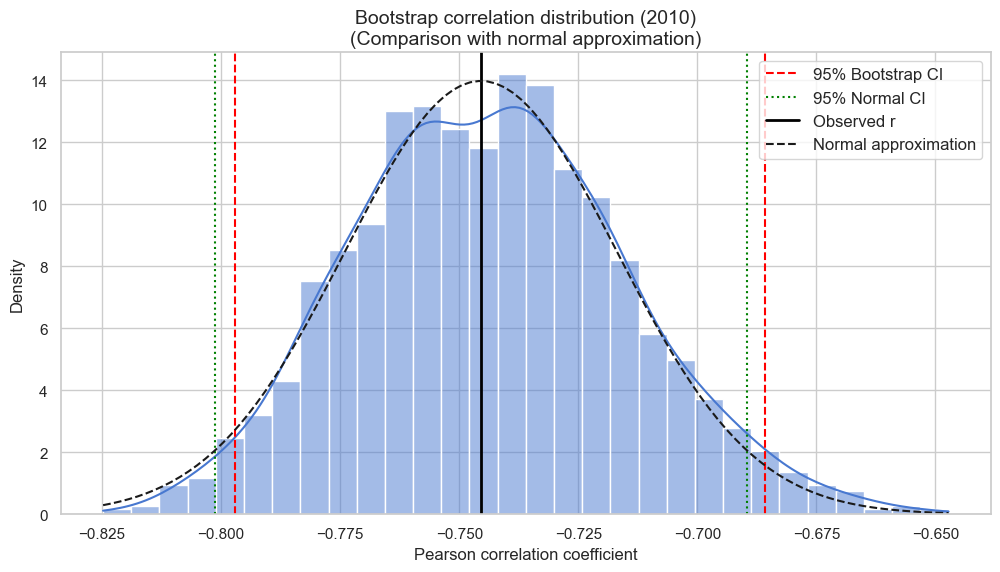

In [24]:
latest = '2010'
res = results[latest]

plt.figure(figsize=(12, 6))

# histogram of bootstrap correlations
sns.histplot(res['boot_corrs'], bins=30, kde=True, stat='density')

# confidence intervals
plt.axvline(res['ci'][0], color='red', linestyle='--', label='95% Bootstrap CI')
plt.axvline(res['ci'][1], color='red', linestyle='--')

# normal approximation CI
plt.axvline(res['norm_ci'][0], color='green', linestyle=':', label='95% Normal CI')
plt.axvline(res['norm_ci'][1], color='green', linestyle=':')

# observed correlation
plt.axvline(res['r_obs'], color='black', linewidth=2, label='Observed r')

# and theoretical normal distribution
x = np.linspace(min(res['boot_corrs']), max(res['boot_corrs']), 100)
plt.plot(x, norm.pdf(x, res['r_obs'], res['se']), 'k--', label='Normal approximation')

plt.title(f'Bootstrap correlation distribution ({latest})\n(Comparison with normal approximation)', fontsize=14)
plt.xlabel('Pearson correlation coefficient', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.show()

### 6.2 Scatter plots with regression lines for different years

Visualizing the raw data relationships :

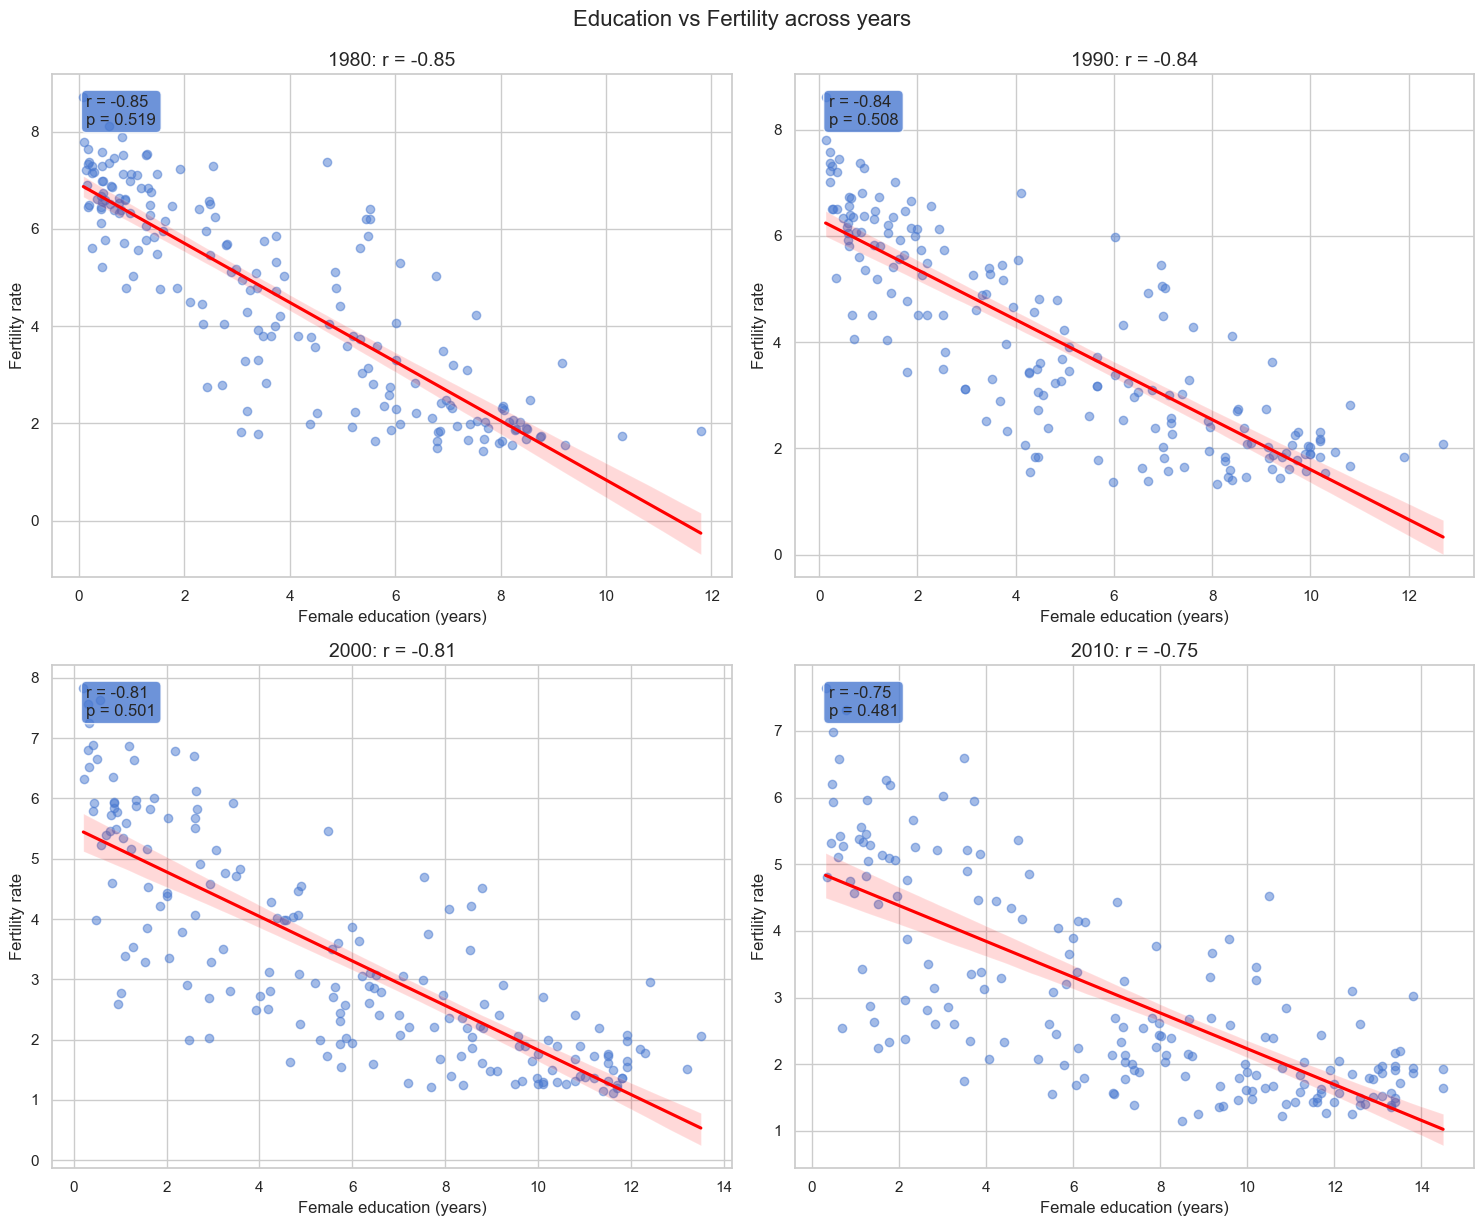

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, year in enumerate(years):
    data = results[year]['data']
    r = results[year]['r_obs']
    
    sns.regplot(x='education', y='fertility', data=data, ax=axes[i], 
               scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    axes[i].set_title(f"{year}: r = {r:.2f}", fontsize=14)
    axes[i].set_xlabel('Female education (years)', fontsize=12)
    axes[i].set_ylabel('Fertility rate', fontsize=12)
    
    # we add correlation and p-value annotation
    axes[i].annotate(f"r = {r:.2f}\np = {results[year]['pval']:.3f}", 
                    xy=(0.05, 0.9), xycoords='axes fraction', 
                    fontsize=12, bbox=dict(boxstyle='round', alpha=0.8))

plt.tight_layout()
plt.suptitle('Education vs Fertility across years', y=1.02, fontsize=16)
plt.show()

### 6.3 Time trend of correlation coefficients

Visualizing how the relationship changes over time:

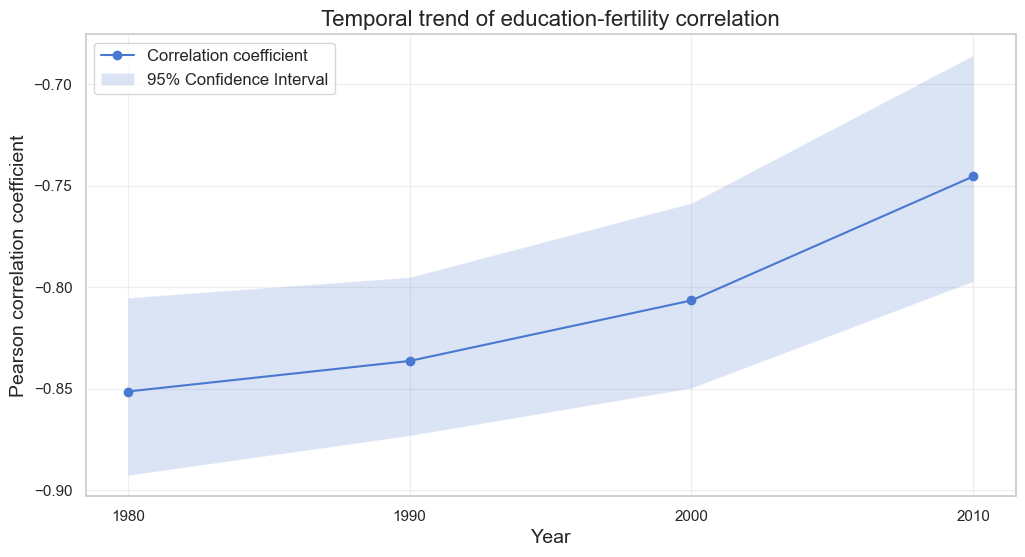

In [26]:
# i extract correlation coefficients and CIs over time
trend_data = pd.DataFrame({
    'Year': years,
    'Correlation': [results[y]['r_obs'] for y in years],
    'CI_lower': [results[y]['ci'][0] for y in years],
    'CI_upper': [results[y]['ci'][1] for y in years]
})

plt.figure(figsize=(12, 6))

# main trend line
plt.plot(trend_data['Year'], trend_data['Correlation'], 'o-', label='Correlation coefficient')

# and confidence intervals
plt.fill_between(trend_data['Year'], trend_data['CI_lower'], trend_data['CI_upper'], 
                 alpha=0.2, label='95% Confidence Interval')

plt.title('Temporal trend of education-fertility correlation', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Pearson correlation coefficient', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 8. Additional analysis: Bootstrap regression 

I extended the analysis with bootstrap regression:

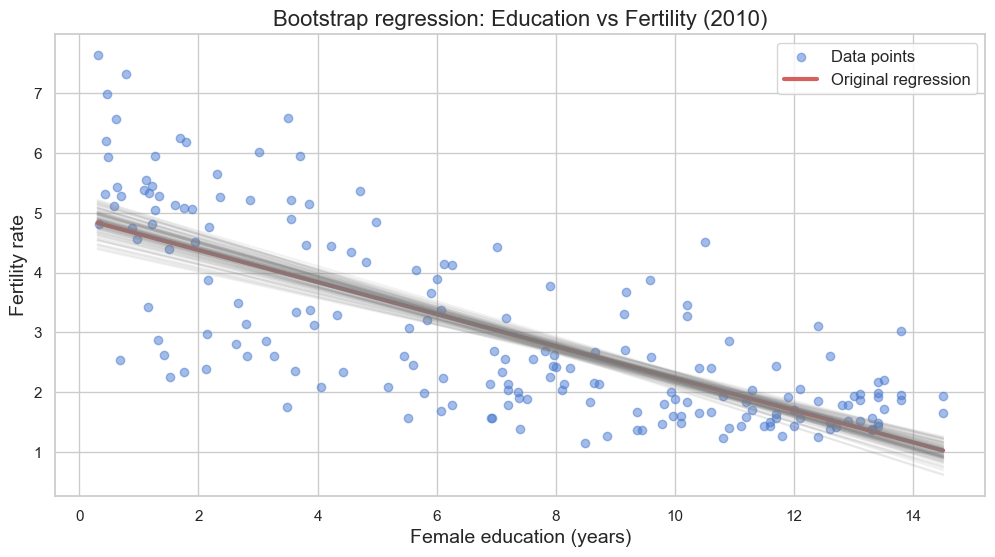

2010 Regression results:
Slope: -0.268 (95% CI: -0.308, -0.231)
Intercept: 4.917 (95% CI: 4.539, 5.280)


In [27]:
def bootstrap_regression(year, n_boot=1000):
    """
    perform bootstrap regression analysis for a given year
    """
    df = results[year]['data']
    X = df['education'].values
    y = df['fertility'].values
    
    # original fit
    coeffs = np.polyfit(X, y, deg=1)
    
    # bootstrap
    boot_coeffs = []
    n = len(df)
    
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        X_boot = X[idx]
        y_boot = y[idx]
        boot_coeffs.append(np.polyfit(X_boot, y_boot, deg=1))
    
    boot_coeffs = np.array(boot_coeffs)
    
    return {
        'year': year,
        'original_coeffs': coeffs,
        'boot_coeffs': boot_coeffs,
        'slope_ci': np.percentile(boot_coeffs[:,0], [2.5, 97.5]),
        'intercept_ci': np.percentile(boot_coeffs[:,1], [2.5, 97.5])
    }

# we perform bootstrap regression for 2010
reg_results = bootstrap_regression('2010')

plt.figure(figsize=(12, 6))

# original data
data = results['2010']['data']
plt.scatter(data['education'], data['fertility'], alpha=0.5, label='Data points')

# original regression line
x_vals = np.linspace(data['education'].min(), data['education'].max(), 100)
y_vals = np.polyval(reg_results['original_coeffs'], x_vals)
plt.plot(x_vals, y_vals, 'r-', linewidth=3, label='Original regression')

# Sample of bootstrap regression lines
for i in range(100):  # we plot the first 100 bootstrap lines
    y_boot = np.polyval(reg_results['boot_coeffs'][i], x_vals)
    plt.plot(x_vals, y_boot, 'gray', alpha=0.1)

plt.title('Bootstrap regression: Education vs Fertility (2010)', fontsize=16)
plt.xlabel('Female education (years)', fontsize=14)
plt.ylabel('Fertility rate', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# and we print regression results
print(f"2010 Regression results:")
print(f"Slope: {reg_results['original_coeffs'][0]:.3f} (95% CI: {reg_results['slope_ci'][0]:.3f}, {reg_results['slope_ci'][1]:.3f})")
print(f"Intercept: {reg_results['original_coeffs'][1]:.3f} (95% CI: {reg_results['intercept_ci'][0]:.3f}, {reg_results['intercept_ci'][1]:.3f})")